# Region growing implementation

This notebooks aims inspect a region growing algorithm that works well for CMB

In [1]:
import utils.utils_loading as utils_load
import numpy as np
import nibabel as nib
import nilearn as nil
import pandas as pd
import SimpleITK as sitk
from tqdm import tqdm
import pickle
import os
from collections import deque
from utils.utils_plotting import plot_mask_on_image
from scipy.ndimage import binary_dilation, binary_erosion, generate_binary_structure, \
    label, center_of_mass, binary_fill_holes



In [2]:
# rawdata
# rawdata_dir = "/datadrive_m2/jorge/data/VALDO"
rawdata_dir = "/home/cerebriu/data/datasets/VALDO"

# newdata
# data_dir = "/datadrive_m2/jorge/TEST/VALDO/Data"
data_dir = "/home/cerebriu/data/datasets/VALDO_processed/Data"
RP_dir = "/home/cerebriu/data/datasets/ResearchProject/"

## Custom implementation

In [3]:
def is_within_bounds(coords, shape):
    """Check if the coordinates are within the bounds of the array."""
    return all(0 <= coords[dim] < shape[dim] for dim, val in enumerate(coords))

def get_neighbors_6n(coords):
    """Get the 6 face-adjacent neighbors in 3D."""
    x, y, z = coords
    return [(x-1, y, z), (x+1, y, z), 
            (x, y-1, z), (x, y+1, z), 
            (x, y, z-1), (x, y, z+1)]

def get_neighbors_26n(coords):
    """Get all 26 possible neighbors in 3D (including diagonals)."""
    neighbors = []
    for x in [-1, 0, 1]:
        for y in [-1, 0, 1]:
            neighbors.extend(
                (coords[0] + x, coords[1] + y, coords[2] + z)
                for z in [-1, 0, 1]
                if (x, y, z) != (0, 0, 0)
            )
    return neighbors

def dice_score(mask1, mask2):
    """Computes the dice score between two binary masks.

    Args:
    mask1: A 3D numpy array of binary values.
    mask2: A 3D numpy array of binary values.

    Returns:
    The dice score, a float value between 0 and 1.
    """
    assert np.any(np.unique(mask1) == np.unique(mask2))
    intersection = np.sum(mask1 & mask2)
    union = np.sum(mask1) + np.sum(mask2)
    return (2 * intersection) / (union)

def calculate_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# Function to get the current intensity based on the mode
def get_current_intensity(point_intensity, neighbor, total_intensity, total_points, intensity_mode , volume):
    if intensity_mode == "point":
        return point_intensity
    elif intensity_mode == "average":
        return total_intensity / total_points if total_points > 0 else 0
    elif intensity_mode == "running_average":
        return (total_intensity + volume[neighbor]) / (total_points + 1)
    else:
        raise ValueError("Invalid intensity mode")
def region_growing_3d_seed(volume, seed_points, tolerance, connectivity=26, size_threshold=200, intensity_mode="point"):
    """
    Grow a region in a 3D volume based on intensity differences with multiple seed points.
    Allows selection between point intensity, average intensity, and running average intensity for region comparison.
    """
    region = np.zeros_like(volume, dtype=bool)  # The resulting binary mask
    queue = deque()  # Initialize the queue with the seed points
    stop_signal = False  # Signal to indicate whether to stop investigating further tolerances
    total_intensity = 0
    total_points = 0

    for seed_point in seed_points:
        if is_within_bounds(seed_point, volume.shape):
            region[seed_point] = True  # Mark the seed point as included in the region
            queue.append(seed_point)
            total_intensity += volume[seed_point]
            total_points += 1

    get_neighbors = get_neighbors_26n if connectivity == 26 else get_neighbors_6n

    while queue:
        point = queue.popleft()  # Get a point from the queue
        point_intensity = volume[point]

        for neighbor in get_neighbors(point):
            if is_within_bounds(neighbor, volume.shape) and not region[neighbor]:
                current_intensity = get_current_intensity(point_intensity, neighbor, total_intensity, total_points, intensity_mode , volume)
                if abs(volume[neighbor] - current_intensity) <= tolerance:
                    region[neighbor] = True  # Include the neighbor in the region
                    queue.append(neighbor)  # Add the neighbor to the queue for further exploration
                    total_intensity += volume[neighbor]
                    total_points += 1

                    # If adding neighbors caused the region to grow too quickly, set the stop signal
                    if np.sum(region) > size_threshold:
                        stop_signal = True
                        print(f"POSSIBLE ERROR: Had to stop execution due to size too big")
                        break

        if stop_signal:
            break

    return region, stop_signal


def region_growing_with_auto_tolerance(volume, seeds, tolerance_range=(0, 100, 1), 
                                        connectivity=26, size_threshold=100, intensity_mode="point"):
    """ 
    Calculates results for several tolerance values and yields optimal based on 
    elbow-method
    """
    grown_regions = []
    exceeded_size_threshold = False
    len_list = []

    # Loop over the tolerance values and perform region growing
    for tolerance in tqdm(np.arange(*tolerance_range), desc="Looping over tolerances"):
        grown_region, exceeded = region_growing_3d_seed(volume, seeds, tolerance, 
                                                        connectivity, size_threshold, intensity_mode)
        grown_regions.append(grown_region)
        len_list.append(np.sum(grown_region))

        # Do not continue if growing exponentially, as computationally very expensive
        if exceeded:
            exceeded_size_threshold = True
            break  # Exit if the size threshold is exceeded

    # Determine the selected tolerance based on the sudden rise (exceeded signal)
    selected_tolerance_index = len(grown_regions) - 2 if exceeded_size_threshold else len(grown_regions) - 1
    selected_tolerance = np.arange(*tolerance_range)[selected_tolerance_index]
    selected_mask = grown_regions[selected_tolerance_index]
    
    # -------------------- Cleaning of mask ----------------------------------
    
    # Define the structure for dilation and erosion based on connectivity
    struct = generate_binary_structure(volume.ndim, connectivity)
    
    # Perform one final dilation and then erosion (closing)
    closed_mask = binary_dilation(selected_mask, structure=struct, iterations=2)
    closed_mask = binary_erosion(closed_mask, structure=struct, iterations=2)
    
    # Fill holes in the mask to ensure it's solid
    closed_mask = binary_fill_holes(closed_mask, structure=struct)

    # Label the connected components
    labeled_mask, num_features = label(closed_mask, structure=struct)

    # If there are multiple features, select the largest one
    if num_features > 1:
        print(f"More than one CC found, a total of {num_features}")
        max_label = 1 + np.argmax([np.sum(labeled_mask == i) for i in range(1, num_features + 1)])
        cleaned_mask = (labeled_mask == max_label)
    else:
        cleaned_mask = closed_mask

    # Metadata
    metadata = {
        'n_pixels': np.sum(cleaned_mask),
        'tolerance_selected': selected_tolerance,
        'tolerance_pixel_counts': len_list
    }

    return cleaned_mask, metadata

### Apply on the whole VALDO dataset

In [5]:
%%capture
import os
import numpy as np
import random
from scipy.ndimage import label as nd_label, measurements

# Initialize a dictionary to store results
subjects = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d)) and d != "sub-218"]
all_results = {}

for method in ['point', 'average', 'running_average']:
    results_dict = {}

    for i, sub_d in enumerate(subjects):
        sub = sub_d.split("-")[1]
        subject_id = f"sub-{sub}"

        print("------------------")
        print(subject_id)

        # rawdata
        mask, t2s, t2, t1 = utils_load.read_all_niftis_raw(sub, rawdata_dir)

        # newdata
        cmb, mri, metadata_raw, metadata_processed = utils_load.read_data_processed(sub, data_dir)

        # data
        cmb_data = cmb.get_fdata()
        t2s_data = mri.get_fdata()[:, :, :, 0]

        # Preprocessing to check and correct mask integrity
        unique_labels, counts = np.unique(cmb_data, return_counts=True)
        if len(unique_labels) > 2:
            raise ValueError(f"More than two unique labels found in the mask for subject {subject_id}.")
        elif len(unique_labels) == 1:
            print(f"Only one label found in mask for subject {subject_id}: {unique_labels[0]}. Setting mask to 0.")
            cmb_data[:] = 0
        else:
            majority_label, minority_label = unique_labels[np.argmax(counts)], unique_labels[np.argmin(counts)]
            cmb_data[cmb_data == majority_label], cmb_data[cmb_data == minority_label] = 0, 1

        # Perform connected components analysis
        labeled_array, n_CMB = nd_label(cmb_data)

        # Initialize a nested dictionary for the subject
        results_dict[subject_id] = {}

        for cmb_number in range(1, n_CMB + 1):
            single_cmb_mask = labeled_array == cmb_number

            if np.sum(single_cmb_mask) > 0:
                cmb_results = {
                    'metadata_processed': metadata_processed,
                    'analysis': {},
                    'processing_metadata': {},
                    'dice_score': None,
                    'num_CMB': cmb_number,
                    'n_vox_orig': np.sum(single_cmb_mask),  # Count of original voxels
                }

                masked_t2s_cmb = t2s_data[single_cmb_mask]
                cmb_min = np.min(masked_t2s_cmb)
                cmb_max = np.max(masked_t2s_cmb)
                cmb_sd = np.std(masked_t2s_cmb)
                cmb_mean = np.mean(masked_t2s_cmb)

                cmb_results['analysis'] = {
                    'min': cmb_min,
                    'max': cmb_max,
                    'mean': cmb_mean,
                    'std': cmb_sd
                }

                # Calculate the center of mass for the connected component
                centerofmass_cmb = measurements.center_of_mass(single_cmb_mask)
                centerofmass_cmb = tuple(int(x) for x in centerofmass_cmb)
                try:
                    single_cmb_mask[centerofmass_cmb]
                except:
                    ones = np.where(single_cmb_mask)
                    points = list(zip(ones[0], ones[1]))
            
                    centerofmass_cmb = random.choice(points)
                    
                seed2use = [centerofmass_cmb]
                
                
                grown_mask, process_metadata = region_growing_with_auto_tolerance(t2s_data,
                                                                                    seeds=seed2use,
                                                                                    tolerance_range=(0, 100, 0.5),
                                                                                    connectivity=6,
                                                                                    intensity_mode=method,
                                                                                    size_threshold=120)

                cmb_results['n_vox_new'] = np.sum(grown_mask)  # Count of grown voxels
                cmb_results['processing_metadata'] = process_metadata
                cmb_results['np_arrays'] = (t2s_data, single_cmb_mask, grown_mask)
                cmb_results['CM'] = centerofmass_cmb
                cmb_results['dice_score'] = dice_score(np.array(single_cmb_mask, int), np.array(grown_mask, int))

                # Store the results for this CMB
                results_dict[subject_id][cmb_number] = cmb_results

        all_results[method] = results_dict



In [31]:
import pickle 
file_pi = open(f'{RP_dir}/all_results_RG.obj', 'wb') 
pickle.dump(all_results, file_pi)
file_pi.close()

In [6]:
import pandas as pd

# List to hold all the rows before creating DataFrame
data_rows = []

# Iterate over each method
for method, subjects in all_results.items():
    # Iterate over each subject
    for subject_id, cmb_data in subjects.items():
        # Extract subject number (assuming subject_id is in format 'sub-{number}')
        sub = subject_id.split('-')[1]

        # Iterate over each CMB
        for cmb_number, cmb_info in cmb_data.items():
            
            original_mask = cmb_info['np_arrays'][1] if 'np_arrays' in cmb_info else None
            grown_mask = cmb_info['np_arrays'][2] if 'np_arrays' in cmb_info else None

            # Prepare a row with relevant data
            row = {
                'method': method,
                'subject': sub,
                'cmb_number': cmb_number,
                'n_vox_GT': cmb_info['n_vox_orig'],  # Number of voxels in the original mask of the connected component
                'n_vox_orig': cmb_info['metadata_processed']['T2S']['pixel_counts'][0] if 'metadata_processed' in cmb_info and 'T2S' in cmb_info['metadata_processed'] and 'pixel_counts' in cmb_info['metadata_processed']['T2S'] else None,
                'n_vox_RG': cmb_info['n_vox_new'],  # Number of voxels in the new mask of the connected component
                'n_vox_new': cmb_info['processing_metadata']['n_pixels'] if 'processing_metadata' in cmb_info and 'n_pixels' in cmb_info['processing_metadata'] else None,
                'dice_score': cmb_info['dice_score'],
                # Assuming iou_score is calculated and stored in a similar way to dice_score
                'iou_score': calculate_iou(original_mask, grown_mask) if original_mask is not None and grown_mask is not None else None,
            }
            data_rows.append(row)

# Create DataFrame
results_df = pd.DataFrame(data_rows)

results_df

,method,subject,cmb_number,n_vox_GT,n_vox_orig,n_vox_RG,n_vox_new,dice_score,iou_score
0,point,232,1,4,4,1,1,0.400000,0.250000
1,point,304,1,17,17,11,11,0.642857,0.473684
2,point,313,1,8,8,6,6,0.714286,0.555556
3,point,111,1,8,8,2,2,0.400000,0.250000
4,point,111,2,58,8,2,2,0.066667,0.034483
...,...,...,...,...,...,...,...,...,...
721,running_average,234,1,6,6,1,1,0.000000,0.000000
722,running_average,234,2,15,6,1,1,0.125000,0.066667
723,running_average,212,1,8,8,2,2,0.400000,0.250000
724,running_average,320,1,3,3,19,19,0.272727,0.157895


### Evaluate against Ground Truth

In [7]:
summary = results_df
summary.sort_values(by=["n_vox_orig"], inplace=True)

(array([ 93., 159., 213.,  51.,  51.,  36.,  12.,  15.,   6.,  12.,   0.,
          6.,   3.,  12.,   9.,   3.,   9.,   3.,   0.,   3.,   3.,   0.,
          0.,   3.,   0.,   3.,   0.,   3.,   3.,   3.,   0.,   0.,   3.,
          3.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   3.]),
 array([  1.  ,   3.92,   6.84,   9.76,  12.68,  15.6 ,  18.52,  21.44,
         24.36,  27.28,  30.2 ,  33.12,  36.04,  38.96,  41.88,  44.8 ,
         47.72,  50.64,  53.56,  56.48,  59.4 ,  62.32,  65.24,  68.16,
         71.08,  74.  ,  76.92,  79.84,  82.76,  85.68,  88.6 ,  91.52,
         94.44,  97.36, 100.28, 103.2 , 106.12, 109.04, 111.96, 114.88,
        117.8 , 120.72, 123.64, 126.56, 129.48, 132.4 , 135.32, 138.24,
        141.16, 144.08, 147.  ]),
 <BarContainer object of 50 artists>)

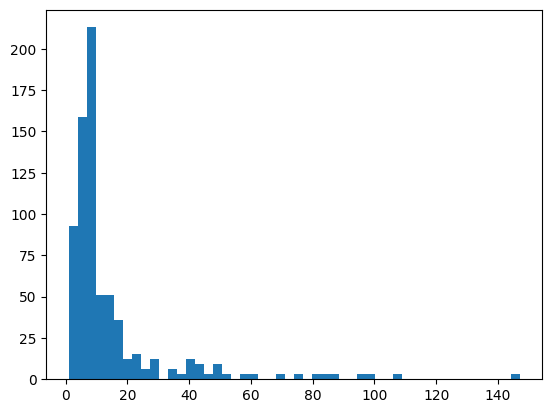

In [8]:
import matplotlib.pyplot as plt
plt.hist(summary['n_vox_GT'], bins=50)

In [9]:
# Group by method and calculate statistics, rounded to 2 decimal places
grouped_by_method = summary.groupby('method').agg({
    'dice_score': ['mean', 'median', 'std'],
    'iou_score': ['mean', 'median', 'std']
}).round(2).reset_index()

# Rename columns for clarity
grouped_by_method.columns = ['method', 'dice_mean', 'dice_median', 'dice_std', 'iou_mean', 'iou_median', 'iou_std']

# Save to a DataFrame
df_method = pd.DataFrame(grouped_by_method)

df_method

,method,dice_mean,dice_median,dice_std,iou_mean,iou_median,iou_std
0,average,0.40,0.38,0.27,0.29,0.24,0.24
1,point,0.39,0.40,0.25,0.28,0.25,0.22
2,running_average,0.40,0.40,0.27,0.29,0.25,0.24


In [10]:
summary.sort_values(by=['subject'])

,method,subject,cmb_number,n_vox_GT,n_vox_orig,n_vox_RG,n_vox_new,dice_score,iou_score
362,average,101,11,7,2,18,18,0.560000,0.388889
122,point,101,13,60,2,26,26,0.558140,0.387097
123,point,101,14,9,2,2,2,0.363636,0.222222
124,point,101,15,10,2,4,4,0.285714,0.166667
125,point,101,16,2,2,20,20,0.181818,0.100000
...,...,...,...,...,...,...,...,...,...
382,average,326,1,13,13,15,15,0.571429,0.400000
624,running_average,326,1,13,13,15,15,0.571429,0.400000
206,point,327,1,7,7,2,2,0.000000,0.000000
690,running_average,327,1,7,7,12,12,0.736842,0.583333


### All CMBs

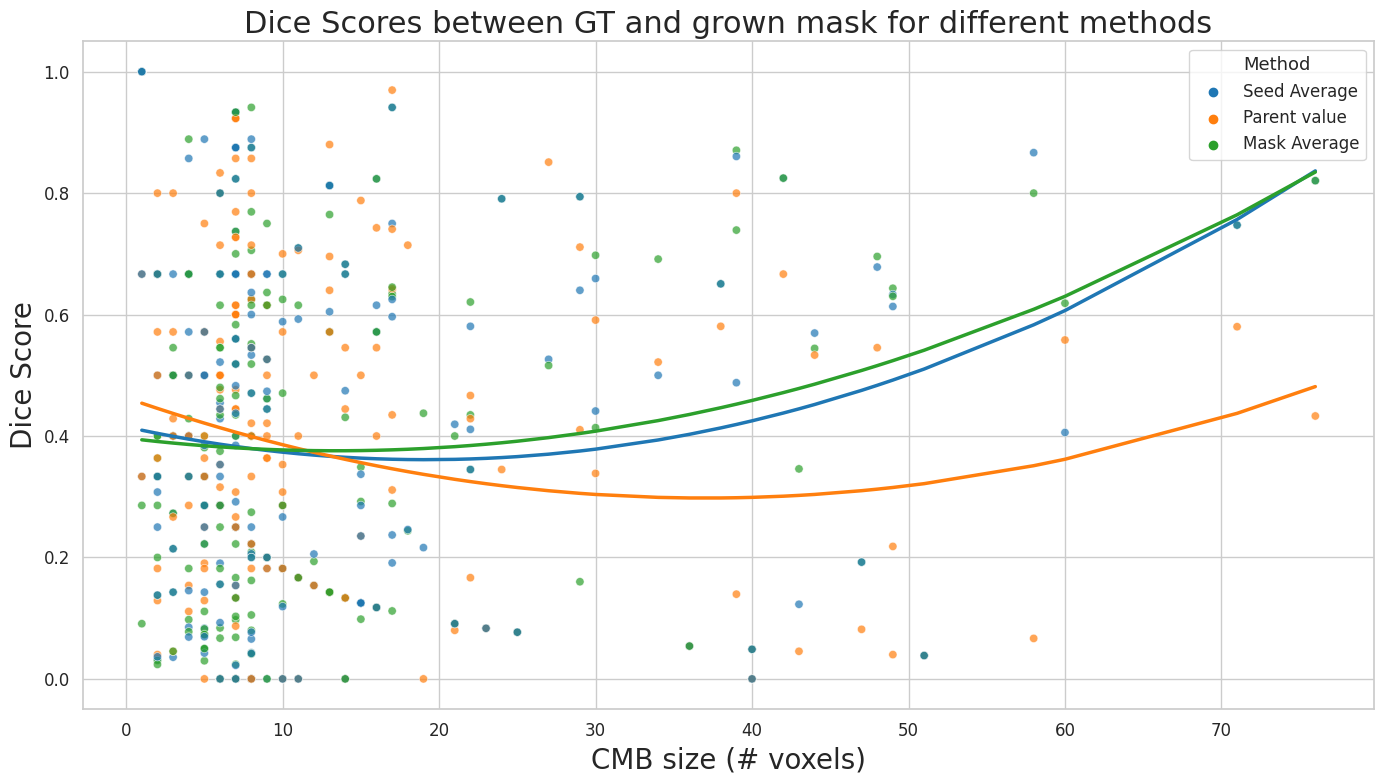

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Renaming in the method column
summary['method'] = summary['method'].replace('average', 'Seed Average')
summary['method'] = summary['method'].replace('running_average', 'Mask Average')
summary['method'] = summary['method'].replace('point', 'Parent value')


summary_f = summary[summary['n_vox_GT'] < 80]

# Setting the style
sns.set(style="whitegrid")

# Using the "tab10" color palette for better contrast
palette = sns.color_palette("tab10", n_colors=3)

# Creating the plot
plt.figure(figsize=(14, 8))

# Plotting scatter plot for each method with alpha for transparency
scatter = sns.scatterplot(data=summary_f, x="n_vox_GT", y="dice_score", hue="method", palette=palette, alpha=0.7)

# Overlaying line plot for each method with interpolation
methods = summary_f['method'].unique()
for i, method in enumerate(methods):
    # Subset for the method
    subset = summary_f[summary_f['method'] == method]
    
    # Sort the data by voxel count for smooth line
    subset_sorted = subset.sort_values('n_vox_GT')
    
    # Interpolation
    x = subset_sorted['n_vox_GT']
    y = subset_sorted['dice_score']
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 2))(np.unique(x)), label=f'', linewidth=2.5, color=palette[i])

# Setting the plot title and labels
plt.title('Dice Scores between GT and grown mask for different methods', fontsize=22)
plt.xlabel('CMB size (# voxels)', fontsize=20)
plt.ylabel('Dice Score', fontsize=20)

# Adjusting the legend
scatter.legend(title='Method', title_fontsize='13', fontsize='12')

# Adjusting the tick sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Displaying the plot with tight layout
plt.tight_layout()


plt.savefig('../img/dice_score_plot.png', dpi=300)

### See example of Elbow method

In [13]:
sub = 'sub-302'
all_results['point'][sub]

{1: {'metadata_processed': {'T2S': {'centers_of_mass': [[117.35526315789474,
      158.56578947368422,
      73.19736842105263]],
    'pixel_counts': [76],
    'radii': [2.627695239855779]}},
  'analysis': {'min': 16.46941566467285,
   'max': 118.2692642211914,
   'mean': 72.61472127312108,
   'std': 24.95142428804752},
  'processing_metadata': {'n_pixels': 21,
   'tolerance_selected': 17.0,
   'tolerance_pixel_counts': [1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    17,
    17,
    18,
    19,
    19,
    20,
    20,
    20,
    20,
    20,
    21,
    121]},
  'dice_score': 0.4329896907216495,
  'num_CMB': 1,
  'n_vox_orig': 76,
  'n_vox_new': 21,
  'np_arrays': (array([[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., 

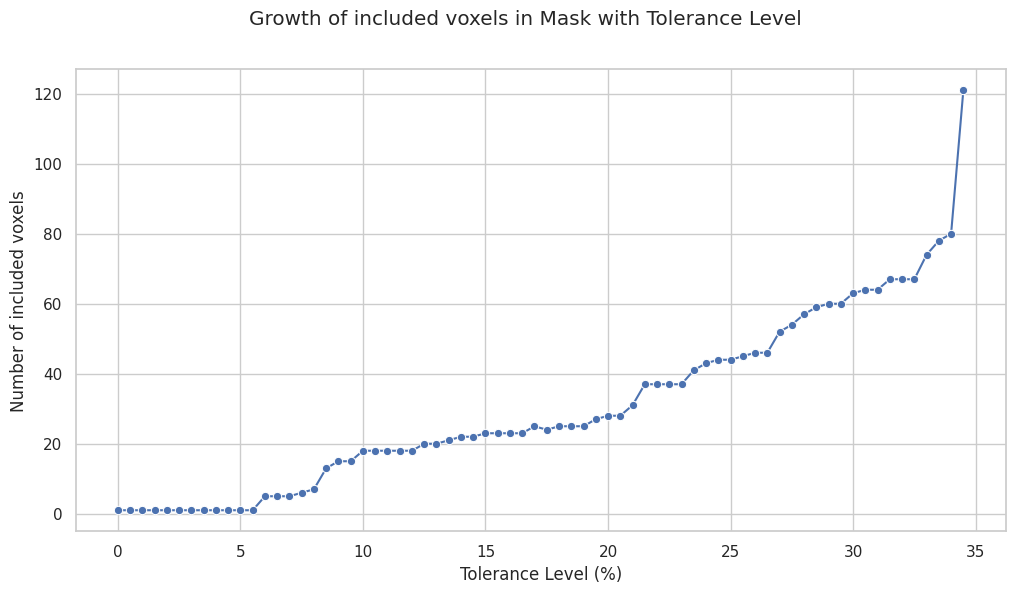

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

tolerance_pixel_counts = all_results['running_average'][sub][1]['processing_metadata']['tolerance_pixel_counts']  # Replace with actual data
tolerance_levels = np.arange(0,  len(tolerance_pixel_counts)/2, 0.5)

# Using Seaborn's style for the plot
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=tolerance_levels, y=tolerance_pixel_counts, marker='o')

# Set the title and axis labels
plt.suptitle("Growth of included voxels in Mask with Tolerance Level")
plt.xlabel("Tolerance Level (%)")
plt.ylabel("Number of included voxels")

# Show the plot
plt.show()
plt.rcdefaults()

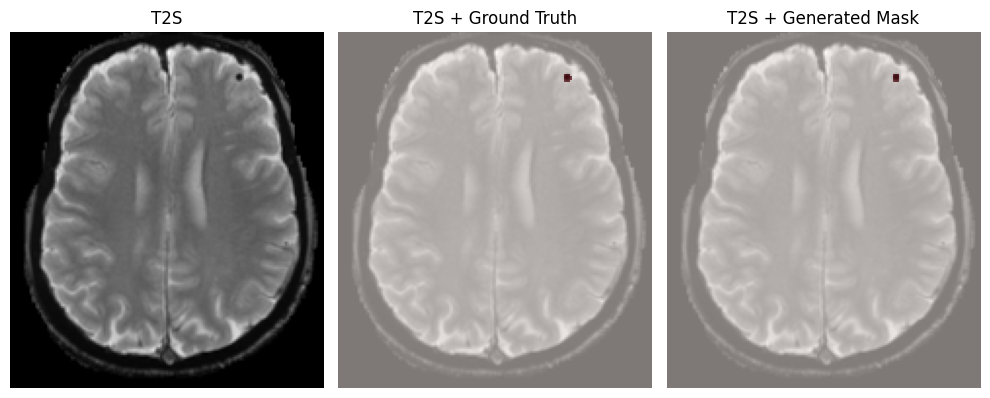

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming t2s_data, cmb_data, and out_mask are numpy arrays from results_dict
t2s_data, cmb_data, out_mask = all_results['running_average'][sub][1]['np_arrays']
CM = all_results['running_average'][sub][1]['CM']

# Creating a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Function to adjust the image for radiological view
def adjust_for_radiological_view(image):
    return np.rot90(image)

# Plotting raw T2 image
axs[0].imshow(adjust_for_radiological_view(t2s_data[:, :, CM[-1]]), cmap='gray')
axs[0].set_title('T2S')

# Plotting ground truth overlay
axs[1].imshow(adjust_for_radiological_view(t2s_data[:, :, CM[-1]]), cmap='gray')
axs[1].imshow(adjust_for_radiological_view(cmb_data[:, :, CM[-1]]), alpha=0.5, cmap="Reds", interpolation='none')
axs[1].set_title('T2S + Ground Truth')

# Plotting generated mask
axs[2].imshow(adjust_for_radiological_view(t2s_data[:, :, CM[-1]]), cmap='gray')
axs[2].imshow(adjust_for_radiological_view(out_mask[:, :, CM[-1]]), alpha=0.5, cmap="Reds", interpolation='none')
axs[2].set_title('T2S + Generated Mask')

# Removing axes for cleaner look
for ax in axs:
    ax.axis('off')

plt.tight_layout()
# Display the plots
plt.show()

plt.savefig('../img/RG_on_.png', dpi=300)

# SimpleITK implementation
inpired by: https://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/30_Segmentation_Region_Growing.html

In [16]:
sub = 102
sub_k = f"sub-{sub}"
t2s_data, cmb_data, out_mask = all_results['running_average'][sub_k][1]['np_arrays']
CM = all_results['running_average'][sub_k][1]['CM']
t2s_sitk = sitk.GetImageFromArray(t2s_data)

# Rescale the intensities and map them to [0,255]
t2s_sitk_255 = sitk.Cast(t2s_sitk, sitk.sitkUInt8)

## ConfidenceConnected

In [17]:
CM_sitk = t2s_sitk.TransformPhysicalPointToIndex(CM)
CM_sitk

(46, 102, 78)

In [18]:
seg_implicit_thresholds = sitk.ConfidenceConnected(t2s_sitk, 
                                                    seedList=[CM_sitk],
                                                    numberOfIterations=3,
                                                    multiplier=1,
                                                    initialNeighborhoodRadius=1,
                                                    replaceValue=1
                                                    )

In [19]:
segmentation_array = sitk.GetArrayFromImage(seg_implicit_thresholds)
t2s_sitk_np = sitk.GetArrayFromImage(t2s_sitk)

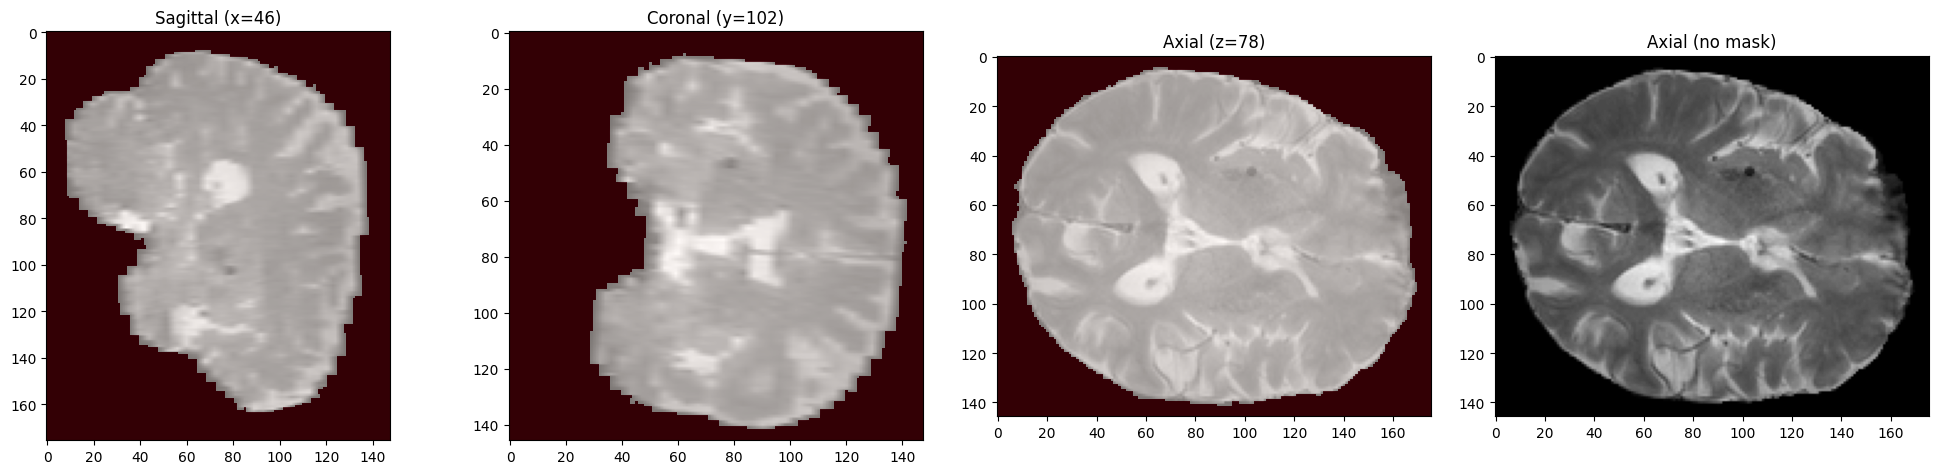

In [20]:
plot_mask_on_image(t2s_sitk_np, segmentation_array, CM)

## VectorConfidenceConnected

In [21]:
NotImplemented

NotImplemented

# Apply to CEREBRIU annotation

Inspect annotated case by Silvia

In [46]:
# studyuid = "e2b08da90ae8beda42b900303fb33fa0d1cf3e07" # small one
studyuid = "1.2.826.1.3680043.9.5282.150415.14832.16014832222376" # big one

data_folder = "/home/cerebriu/data/datasets/CMB_newdataset"
mri_dir = f"{data_folder}/images/{studyuid}/T2S_0"
cmb_nib = nib.load(f"{data_folder}/segmentations//{studyuid}/T2S_0.nii.gz")
t2s_nib = nib.load([os.path.join(mri_dir, f) for f in os.listdir(mri_dir) if "T2S" in f][0])

cmb_data_crbr = cmb_nib.get_fdata()
t2s_data_crbr = t2s_nib.get_fdata()

In [47]:
print(t2s_data_crbr.shape,
cmb_data_crbr.shape)

(270, 320, 29) (270, 320, 29)


In [48]:
np.unique(cmb_data_crbr)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [49]:
# cmb_data[cmb_data == 1] = 0 # in case needed
lab = 1
cmb_data_crbr[cmb_data_crbr != lab] = 0 # in case needed

np.sum(cmb_data_crbr == 1)
cmb_coord_where = np.where(cmb_data_crbr == lab)
cmb_coord = [(cmb_coord_where[0][i], cmb_coord_where[1][i], cmb_coord_where[2][i]) for i in range(len(cmb_coord_where[0]))]
cmb_coord

[(110, 186, 23), (110, 187, 23)]

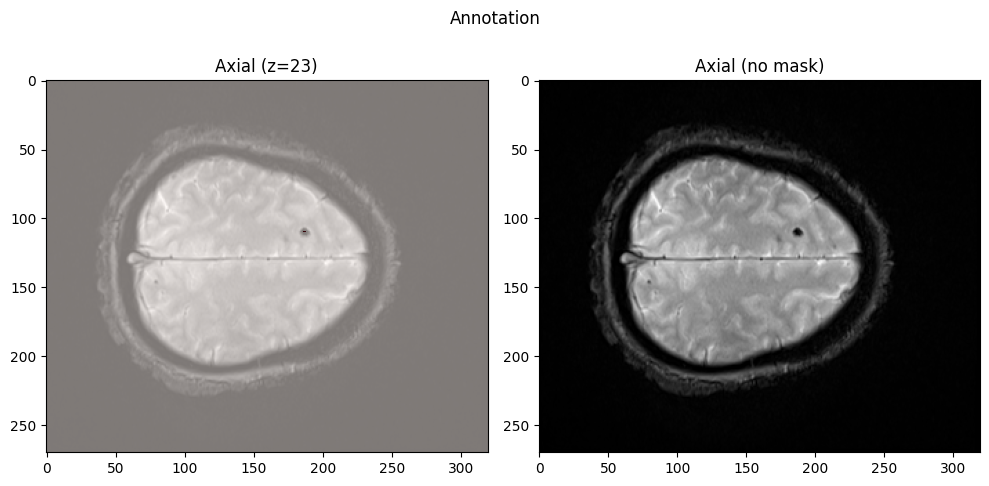

In [50]:
plot_mask_on_image(t2s_data_crbr, cmb_data_crbr, cmb_coord[0], axes_to_display=['axial'], title="Annotation")

In [51]:
masked_t2s_cmb = t2s_data_crbr[cmb_data_crbr == 1]
cmb_min = np.min(masked_t2s_cmb)
cmb_max = np.max(masked_t2s_cmb)
cmb_sd = np.std(masked_t2s_cmb)
cmb_mean = np.mean(masked_t2s_cmb)
print(
    f"min: {cmb_min} "
    f"max: {cmb_max} "
    f"mean: {cmb_mean} "
    f"std: {cmb_sd}"
)
from scipy.ndimage import label
grown_mask_crbr, process_metadata = region_growing_with_auto_tolerance(t2s_data_crbr, 
                                                                    seeds=cmb_coord, 
                                                                    tolerance_range=(0, 100, 1), 
                                                                    connectivity=6,
                                                                    size_threshold=160,
                                                                    intensity_mode="average"
                                                                    )


min: 1.0 max: 34.0 mean: 17.5 std: 16.5


Looping over tolerances: 100%|██████████| 100/100 [00:01<00:00, 56.03it/s]


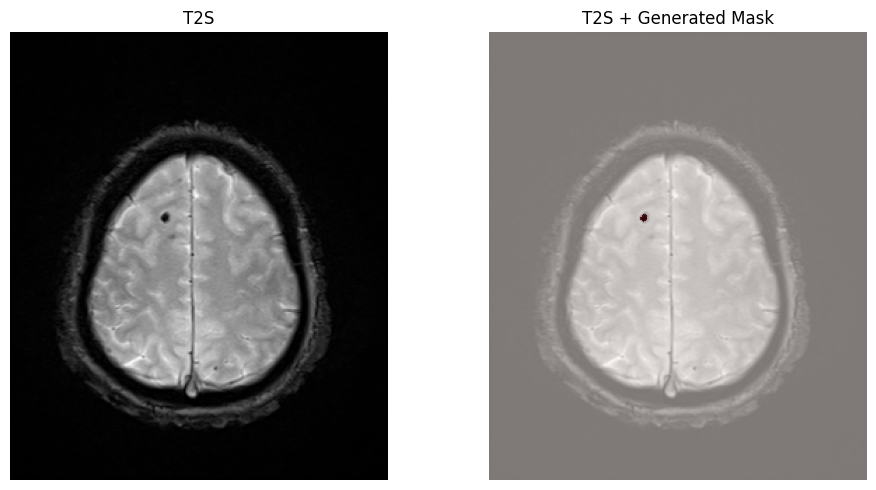

<Figure size 640x480 with 0 Axes>

In [54]:
import matplotlib.pyplot as plt
import numpy as np

CM_crbr = cmb_coord[0]

# Creating a figure with three subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Function to adjust the image for radiological view
def adjust_for_radiological_view(image):
    return np.rot90(image)

# Plotting raw T2 image
axs[0].imshow(adjust_for_radiological_view(t2s_data_crbr[:, :, CM_crbr[-1]]), cmap='gray')
axs[0].set_title('T2S')

# Plotting generated mask
axs[1].imshow(adjust_for_radiological_view(t2s_data_crbr[:, :, CM_crbr[-1]]), cmap='gray')
axs[1].imshow(adjust_for_radiological_view(grown_mask_crbr[:, :, CM_crbr[-1]]), alpha=0.5, cmap="Reds", interpolation='none')
axs[1].set_title('T2S + Generated Mask')

# Removing axes for cleaner look
for ax in axs:
    ax.axis('off')

plt.tight_layout()
# Display the plots
plt.show()

plt.savefig('../img/RG_on_CEREBRIU.png', dpi=300)


### Combine results from different origins

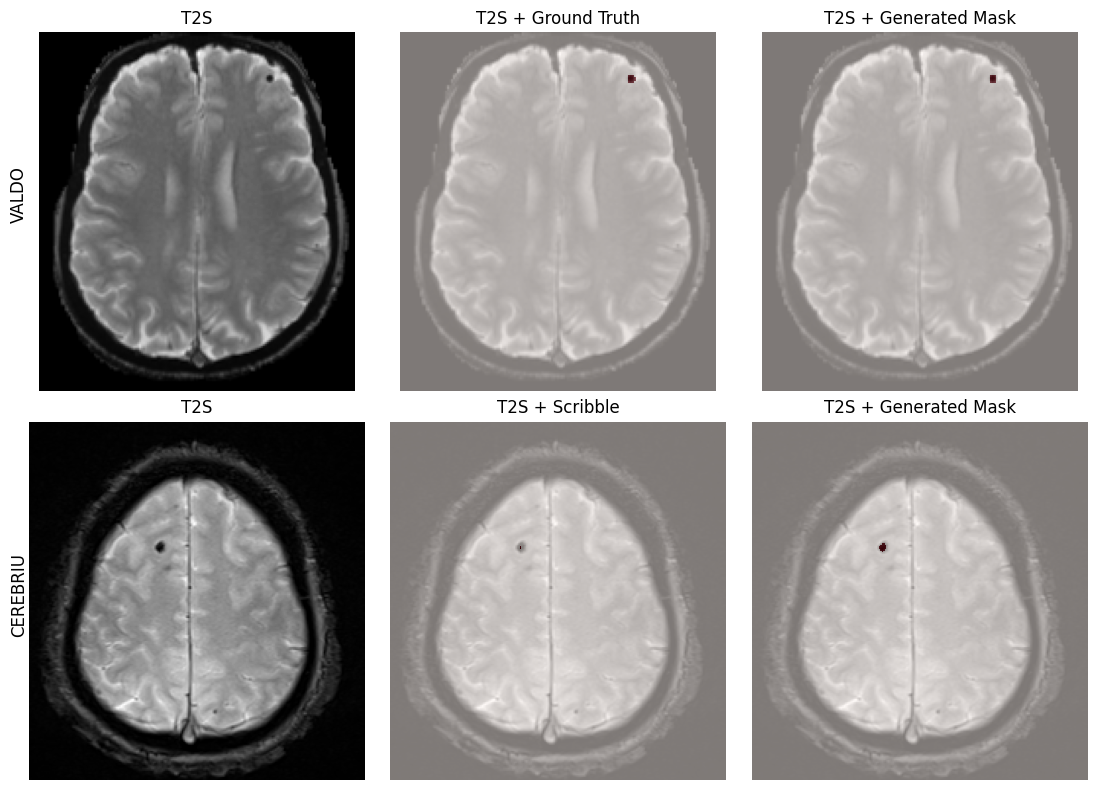

In [55]:
import matplotlib.pyplot as plt
import numpy as np
sub = 302

# Function to adjust the image for radiological view
def adjust_for_radiological_view(image):
    return np.rot90(image)

# Assuming t2s_data, cmb_data, and out_mask are numpy arrays from results_dict
t2s_data, cmb_data, out_mask = all_results['running_average'][f"sub-{sub}"][1]['np_arrays']
CM = all_results['running_average'][f"sub-{sub}"][1]['CM']

# Cropping the CEREBRIU images (adjust the slice as needed)
crop_slice = (slice(25, -25), slice(35, -50), slice(None))
t2s_data_crbr_cropped = t2s_data_crbr[crop_slice]
grown_mask_crbr_cropped = grown_mask_crbr[crop_slice]
cmb_data_crbr_cropped = cmb_data_crbr[crop_slice]

# Creating a figure with 3x3 subplots
fig, axs = plt.subplots(2, 3, figsize=(11, 8))

# First row (VALDO data with GT)
# Raw T2 image
axs[0, 0].imshow(adjust_for_radiological_view(t2s_data[:, :, CM[-1]]), cmap='gray')
axs[0, 0].set_title('T2S')

# T2 image with ground truth overlay
axs[0, 1].imshow(adjust_for_radiological_view(t2s_data[:, :, CM[-1]]), cmap='gray')
axs[0, 1].imshow(adjust_for_radiological_view(cmb_data[:, :, CM[-1]]), alpha=0.5, cmap="Reds", interpolation='none')
axs[0, 1].set_title('T2S + Ground Truth')

# T2 image with generated mask
axs[0, 2].imshow(adjust_for_radiological_view(t2s_data[:, :, CM[-1]]), cmap='gray')
axs[0, 2].imshow(adjust_for_radiological_view(out_mask[:, :, CM[-1]]), alpha=0.5, cmap="Reds", interpolation='none')
axs[0, 2].set_title('T2S + Generated Mask')




# Second row (Own annotated data without GT)
# Raw T2 image
axs[1, 0].imshow(adjust_for_radiological_view(t2s_data_crbr_cropped[:, :, CM_crbr[-1]]), cmap='gray')
axs[1, 0].set_title('T2S')


# T2 image with generated mask
axs[1, 1].imshow(adjust_for_radiological_view(t2s_data_crbr_cropped[:, :, CM_crbr[-1]]), cmap='gray')
axs[1, 1].imshow(adjust_for_radiological_view(cmb_data_crbr_cropped[:, :, CM_crbr[-1]]), alpha=0.5, cmap="Reds", interpolation='none')
axs[1, 1].set_title('T2S + Scribble')

# T2 image with generated mask
axs[1, 2].imshow(adjust_for_radiological_view(t2s_data_crbr_cropped[:, :, CM_crbr[-1]]), cmap='gray')
axs[1, 2].imshow(adjust_for_radiological_view(grown_mask_crbr_cropped[:, :, CM_crbr[-1]]), alpha=0.5, cmap="Reds", interpolation='none')
axs[1, 2].set_title('T2S + Generated Mask')

# Leaving the third plot in the second row empty
axs[1, 1].axis('off')

# Removing axes for cleaner look
for ax in axs.flat:
    ax.axis('off')

# Adding data source indicators
fig.text(0.01, 0.75, 'VALDO', ha='center', va='center', rotation='vertical', fontsize=12)
fig.text(0.01, 0.25, 'CEREBRIU', ha='center', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()

plt.savefig('../img/combined_images.png', dpi=500)

plt.show()

